# SNU PLANETA - 화산암 지각 두께 유추 문제
**best accuracy: 91.8%**

[2. 극지] 화산암 지각 두께 유추 문제

화산암 구성원소 정보를 이용하여 추출된 지각을 두께에 따른 카테고리로 분류

- 첨부된 지구화학 데이터는 두꺼운 지각 (>50 km; Andes arc) 및 얇은 지각 (< 20 km; Mariana and Tonga arc)의 화산호에서 채취된 화산암의 전암 (wholerock) 주원소, 미량원소 데이터입니다.
- AI를 이용하여 두 그룹의 화산암의 조성을 학습시키고 미지의 화산암 데이터가 주어졌을 때 지각의 두께가 두꺼운지 얇은지를 분류하는 모델을 만드는 과제입니다.
- 첨부된 데이터는 총 4개 지역을 병합한 결과이며, 아래와 같은 특징을 갖고있습니다.
>CVZ_Andes arc: 안데스 화산호의 CVZ지역 (두꺼운 지각)  
NVZ_Andes arc: 안데스 화산호의 NVZ지역 (두꺼운 지각)  
Mariana arc: 마리아나 화산호 (얇은 지각)  
Tonga arc: 통가 화산호 (얇은 지각)  
Mafic: 염기성암 (>7 wt.% MgO)  
Int_felsic: 중성-산성암 (<7 wt.% MgO)  

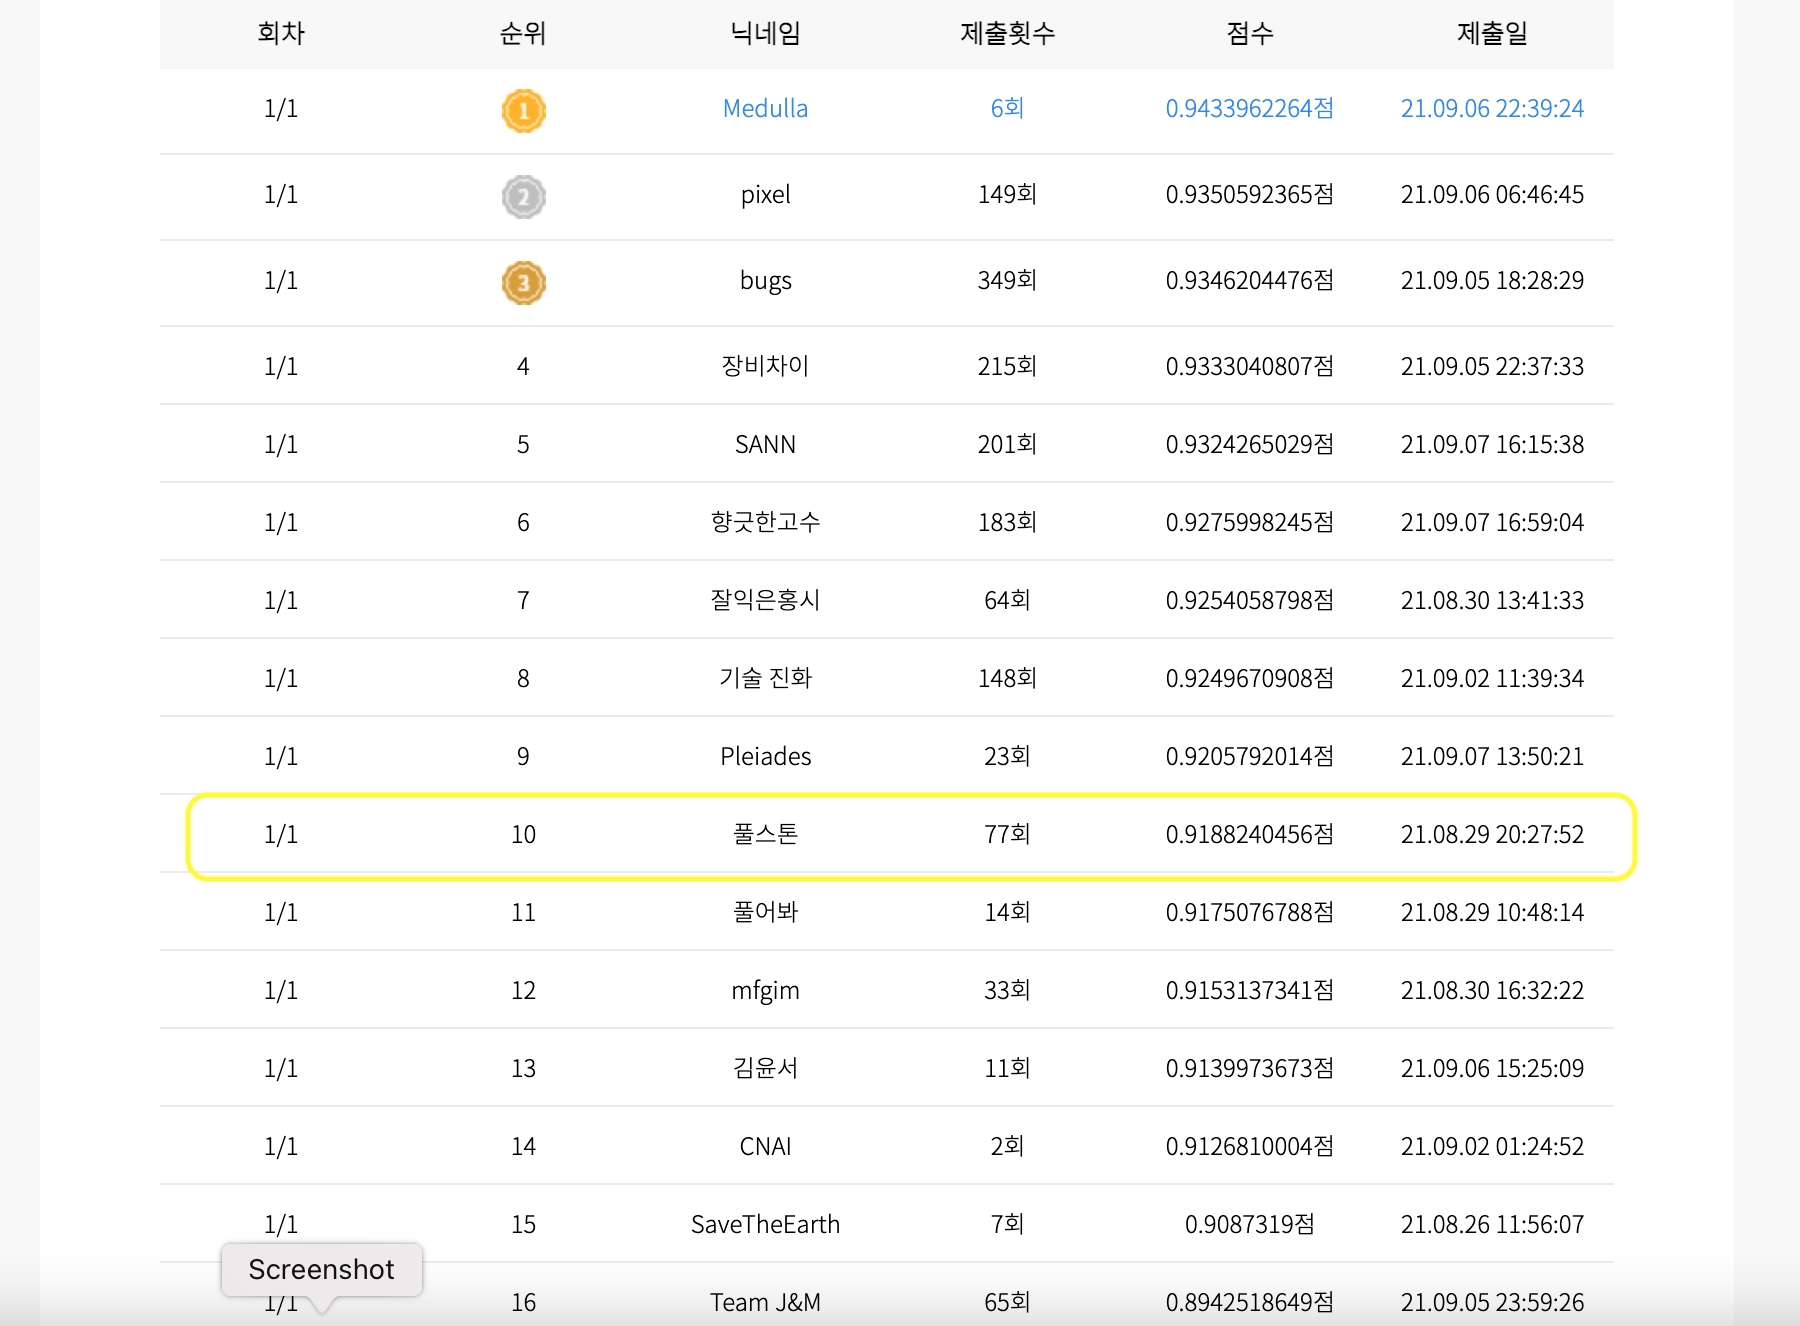

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

tf.random.set_seed(7)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Load

In [3]:
data_path = '/content/drive/MyDrive/data/planeta'
train = pd.read_csv(os.path.join(data_path, 'train_data.csv'))
train.head(10)

,TIO2(WT%),AL2O3(WT%),FEOT(WT%),CAO(WT%),MGO(WT%),MNO(WT%),K2O(WT%),NA2O(WT%),P2O5(WT%),SC(PPM),V(PPM),CR(PPM),CO(PPM),NI(PPM),CU(PPM),ZN(PPM),RB(PPM),SR(PPM),Y(PPM),ZR(PPM),NB(PPM),CS(PPM),BA(PPM),LA(PPM),CE(PPM),PR(PPM),ND(PPM),SM(PPM),EU(PPM),GD(PPM),TB(PPM),DY(PPM),HO(PPM),ER(PPM),TM(PPM),YB(PPM),LU(PPM),HF(PPM),TA(PPM),PB(PPM),TH(PPM),U(PPM),Thickness
0,0.560000,16.000000,6.703510,6.600000,5.100000,0.11000,1.300000,3.610000,0.150000,18.000000,177.000,165.00000,33.00,81.0,NaN,NaN,29.000000,505.000000,10.800000,81.000000,3.000000,NaN,550.000000,12.100000,25.000000,NaN,13.000000,2.600000,0.770000,2.40000,NaN,2.000000,NaN,1.10000,NaN,0.990000,NaN,NaN,NaN,NaN,2.650000,NaN,0
1,1.130000,17.210000,8.886916,12.120000,7.680000,0.15000,0.240000,2.700000,0.100000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,0.530000,16.150000,2.996334,3.980000,1.990000,0.06000,2.180000,4.580000,0.180000,8.050000,68.700,47.80000,6.38,10.8,6.49000,80.40000,65.200000,756.000000,11.500000,161.000000,5.650000,2.140000,1521.000000,24.800000,47.500000,5.92000,22.700000,4.230000,1.110000,3.50000,0.461000,2.400000,0.429000,1.13000,0.156000,1.000000,0.142000,NaN,0.339000,16.700000,7.000000,2.350000,0
3,1.150000,15.100000,7.891246,7.740000,7.930000,0.12000,1.670000,3.010000,0.270000,24.050000,NaN,NaN,NaN,NaN,NaN,NaN,47.000000,490.000000,18.830000,172.000000,12.500000,1.310000,409.000000,35.300000,67.900000,7.51000,30.300000,5.720000,1.390000,5.20000,0.660000,3.840000,0.700000,1.98000,0.300000,1.880000,0.260000,6.740000,0.780000,9.100000,7.600000,1.200000,0
4,0.420000,15.950000,3.761164,4.090000,1.900000,0.06000,2.470000,4.420000,0.140000,7.000000,54.000,32.00000,11.00,16.0,NaN,NaN,68.000000,555.000000,7.000000,28.000000,3.600000,NaN,935.000000,23.000000,43.000000,NaN,18.500000,3.400000,0.900000,2.40000,NaN,1.350000,NaN,0.60000,NaN,0.500000,NaN,NaN,NaN,NaN,5.100000,NaN,0
5,0.370000,15.600000,2.166834,1.720000,1.370000,0.05000,4.320000,3.180000,0.240000,7.000000,58.000,61.00000,7.30,22.0,24.00000,87.00000,373.000000,195.000000,19.000000,152.000000,12.000000,105.000000,820.000000,40.400000,80.600000,NaN,35.100000,4.900000,1.040000,NaN,0.340000,NaN,NaN,NaN,NaN,1.310000,0.190000,5.000000,2.900000,62.000000,22.200000,14.600000,0
6,0.650000,16.500000,5.128860,5.000000,2.640000,0.09000,2.420000,4.140000,0.200000,10.900000,127.000,32.00000,16.50,27.0,NaN,NaN,47.500000,680.000000,12.000000,120.000000,5.500000,NaN,990.000000,25.000000,45.000000,NaN,20.000000,3.700000,1.030000,3.35000,NaN,2.150000,NaN,1.10000,NaN,1.040000,NaN,NaN,NaN,NaN,3.000000,NaN,0
7,0.560000,16.800000,5.173850,5.980000,3.450000,0.10000,1.370000,3.710000,0.160000,14.000000,120.000,112.00000,18.00,33.0,NaN,NaN,26.000000,510.000000,10.400000,78.000000,4.000000,NaN,600.000000,12.200000,23.500000,NaN,13.500000,NaN,0.770000,NaN,NaN,1.900000,NaN,1.10000,NaN,0.950000,NaN,NaN,NaN,NaN,2.500000,NaN,0
8,1.618579,13.456672,6.442568,13.126606,10.654914,0.20247,1.326228,2.703669,0.916604,29.733778,302.514,468.36075,NaN,NaN,188.47575,109.07575,83.142693,1455.172778,27.738894,164.805672,22.120503,1.006771,1016.289592,57.655516,121.236541,15.17592,61.428078,11.834762,3.390597,9.15931,1.222219,6.209152,1.108197,2.65357,0.347112,1.996277,0.288843,4.132123,1.194383,7.891174,6.963459,2.021621,0
9,0.750000,17.650000,6.226616,6.150000,2.980000,0.12000,2.090000,4.480000,0.370000,10.700000,144.000,26.00000,21.00,25.0,NaN,NaN,51.800000,890.000000,14.000000,155.000000,9.000000,NaN,1230.000000,31.500000,59.000000,NaN,26.500000,5.100000,1.390000,3.90000,NaN,2.500000,NaN,1.25000,NaN,1.190000,NaN,NaN,NaN,NaN,5.650000,NaN,0


In [4]:
test = pd.read_csv(os.path.join(data_path,'test_input.csv'))
test.tail(10)

,TIO2(WT%),AL2O3(WT%),FEOT(WT%),CAO(WT%),MGO(WT%),MNO(WT%),K2O(WT%),NA2O(WT%),P2O5(WT%),SC(PPM),V(PPM),CR(PPM),CO(PPM),NI(PPM),CU(PPM),ZN(PPM),RB(PPM),SR(PPM),Y(PPM),ZR(PPM),NB(PPM),CS(PPM),BA(PPM),LA(PPM),CE(PPM),PR(PPM),ND(PPM),SM(PPM),EU(PPM),GD(PPM),TB(PPM),DY(PPM),HO(PPM),ER(PPM),TM(PPM),YB(PPM),LU(PPM),HF(PPM),TA(PPM),PB(PPM),TH(PPM),U(PPM)
2269,0.40000,21.57000,3.941124,6.80000,1.36000,0.10000,0.46000,3.06000,0.09000,17.800000,85.300000,4.300000,9.000000,3.600000,62.200000,41.700000,8.500000,281.000000,30.900000,56.300000,0.550000,0.470000,180.000000,3.110000,8.10000,1.330000,6.920000,2.290000,0.820000,3.370000,0.610000,4.270000,0.980000,2.940000,0.464970,3.080000,0.490000,1.810000,0.060000,2.310000,0.200000,0.130000
2270,0.65000,17.46000,8.593090,10.81000,4.95000,0.15000,0.48000,2.11000,0.13000,36.118290,269.757853,44.193436,31.021354,21.427121,108.814594,67.659331,7.495495,223.065919,18.220448,35.204839,0.424945,0.225864,143.493749,3.304014,8.18508,1.271636,6.302212,1.982009,0.691384,2.422544,0.428742,2.830299,0.604637,1.752077,0.263442,1.792523,0.269838,1.178432,0.030102,1.847290,0.439536,0.175874
2271,0.56000,13.48000,6.481744,4.00000,0.81000,0.13000,1.20000,3.34000,0.16000,16.452675,21.000000,0.000000,7.459263,0.000000,22.045179,77.744164,10.000000,118.000000,34.000000,99.000000,0.000000,0.371003,31.000000,5.063336,11.76000,1.809540,8.150000,2.620000,0.810000,3.980000,0.714481,4.520000,1.074821,3.180000,0.543425,3.620000,0.578939,2.743930,0.194792,3.231330,0.564366,0.380055
2272,1.41718,16.91622,9.649700,12.38164,8.60082,0.16196,0.08974,2.48242,0.13602,42.854886,249.285000,241.492266,43.096139,118.970060,135.349998,68.196669,1.969652,171.386351,27.968426,95.708610,2.338742,0.009085,18.244191,3.287895,8.94481,1.554933,8.848187,2.995435,1.114527,4.183705,0.744445,4.856263,0.984690,2.868637,0.415610,2.642488,0.425735,2.235098,0.162989,0.418798,0.243223,0.054186
2273,0.75000,17.48000,7.432348,4.81000,2.60000,0.18000,0.49000,3.75000,0.08000,29.000000,136.000000,2.000000,10.000000,3.000000,28.000000,66.000000,2.200000,119.000000,20.900000,60.000000,0.720000,0.020000,29.000000,2.010000,6.59000,1.170000,6.230000,2.250000,0.890000,3.100000,0.550000,3.660000,0.790000,2.370000,0.350000,2.220000,0.340000,1.600000,0.092000,1.080000,0.060000,0.060000
2274,0.69000,16.95000,5.083870,5.20000,2.30000,0.09000,2.36000,4.15000,0.28000,9.500000,112.000000,18.000000,15.000000,16.000000,46.958837,80.486079,47.000000,810.000000,12.200000,172.000000,6.900000,1.135212,1080.000000,34.500000,65.00000,7.600183,29.500000,4.633958,1.260000,3.450670,0.456055,2.200000,0.433886,1.300000,0.172841,1.030000,0.159228,4.141983,0.494936,11.236254,3.400000,0.716591
2275,1.81000,16.70000,7.576316,6.88000,4.27000,0.09000,2.26000,4.23000,0.75000,3.000000,62.000000,1.000000,1.000000,2.000000,20.000000,37.000000,235.898000,20.797000,18.312000,89.982000,21.559000,6.400000,47.700000,25.442000,56.50000,6.069000,20.949000,3.996000,0.262000,3.208000,0.437000,2.759000,0.526000,1.428000,0.276000,1.784000,0.261000,3.129000,2.372000,20.585000,37.332000,8.223000
2276,0.80000,14.60000,5.700000,3.60000,1.20000,0.16000,2.80000,3.60000,0.28000,17.000000,39.248826,1.000000,9.000000,1.000000,23.000000,92.750800,51.000000,222.000000,39.000000,208.000000,7.000000,1.700000,451.000000,15.480000,34.53000,4.900000,22.240000,5.950000,1.480000,6.500000,1.070000,6.920000,1.440000,4.310000,0.640000,4.310000,0.640000,5.530000,0.524752,6.600000,2.600000,1.400000
2277,2.65000,14.10000,11.060000,5.70000,1.80000,0.22000,2.40000,3.40000,0.64000,19.766414,215.934803,57.331893,30.571087,31.335708,52.837793,248.508029,76.846510,815.428355,31.281400,181.783300,23.875300,4.855954,938.798406,27.340100,58.15418,6.790612,26.533387,5.863727,1.671801,5.512085,0.839273,4.590835,0.878585,2.371511,0.349851,2.238685,0.333215,4.601026,1.425870,33.617685,8.423876,2.131333
2278,0.13000,14.60000,0.950000,0.81000,0.25000,0.02000,4.95000,2.93000,0.30000,3.321239,17.975490,2.200000,7.760644,8.173739,35.945773,65.

# Preprocess & EDA

In [5]:
train = train.drop_duplicates()

In [6]:
groups = train.groupby('Thickness')
thick_df = groups.get_group(1).reset_index(drop=True)
thin_df = groups.get_group(0).reset_index(drop=True)

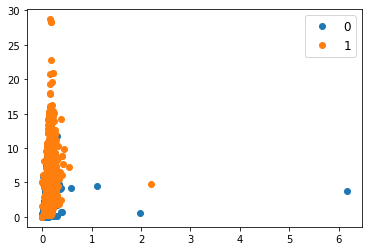

In [7]:
fig, ax = plt.subplots()

for name, group in groups:

    ax.plot(group['MNO(WT%)'], 

            group['MGO(WT%)'], 

            marker='o', 

            linestyle='',

            label=name)
ax.legend(fontsize=12, loc='upper right')
plt.show()

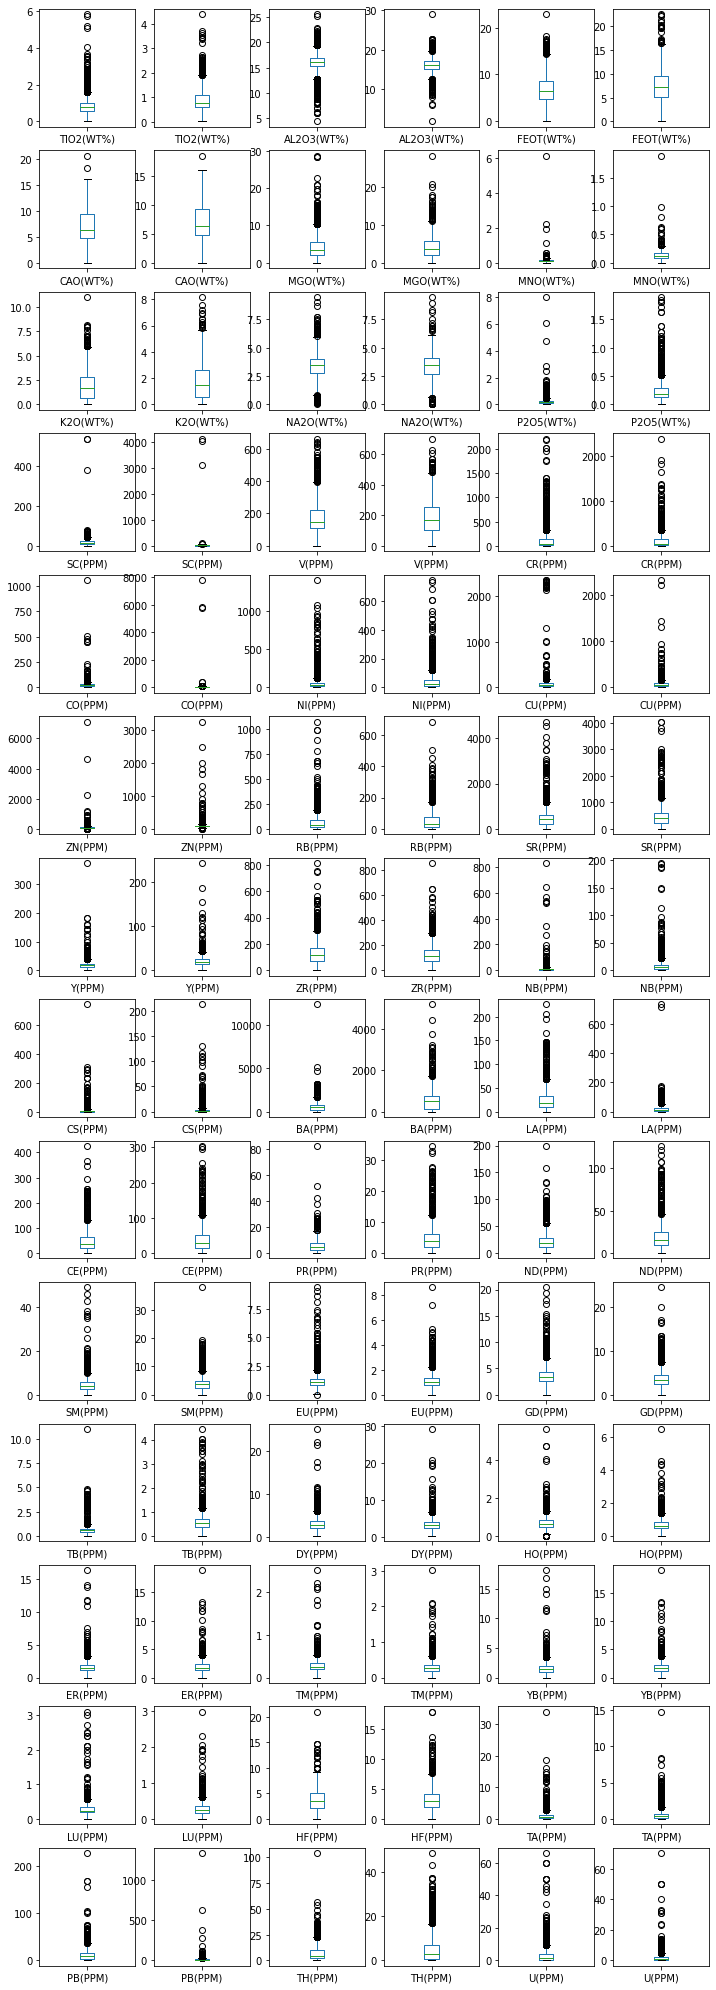

In [8]:
fig = plt.figure(figsize=(12, 36))
for i, col in enumerate(list(test.columns)):
  ax = fig.add_subplot(14, 6, 2*i+1 )
  train[col].plot.box()
  ax = fig.add_subplot(14, 6, 2*i+2 )
  test[col].plot.box()
plt.show()

In [9]:
# 이상치 처리
train_mask = train['MNO(WT%)'] < 4.0
train = train[train_mask]

In [10]:
num_train = train.shape[0]
print(num_train)

7273


In [11]:
cols = train.columns

In [12]:
y = train['Thickness']
train = train.drop(['Thickness'], axis=1)

In [13]:
train.isnull().sum()

TIO2(WT%)        5
AL2O3(WT%)       0
FEOT(WT%)        0
CAO(WT%)         0
MGO(WT%)         1
MNO(WT%)         0
K2O(WT%)         2
NA2O(WT%)        1
P2O5(WT%)      126
SC(PPM)       3344
V(PPM)        2434
CR(PPM)       2004
CO(PPM)       3776
NI(PPM)       1776
CU(PPM)       4975
ZN(PPM)       4814
RB(PPM)       1556
SR(PPM)       1266
Y(PPM)        1717
ZR(PPM)       1557
NB(PPM)       2108
CS(PPM)       5157
BA(PPM)       1539
LA(PPM)       2551
CE(PPM)       2504
PR(PPM)       5279
ND(PPM)       2772
SM(PPM)       3146
EU(PPM)       3051
GD(PPM)       3994
TB(PPM)       4551
DY(PPM)       3743
HO(PPM)       5234
ER(PPM)       3866
TM(PPM)       5524
YB(PPM)       3066
LU(PPM)       4577
HF(PPM)       4658
TA(PPM)       4830
PB(PPM)       4459
TH(PPM)       2894
U(PPM)        4499
dtype: int64

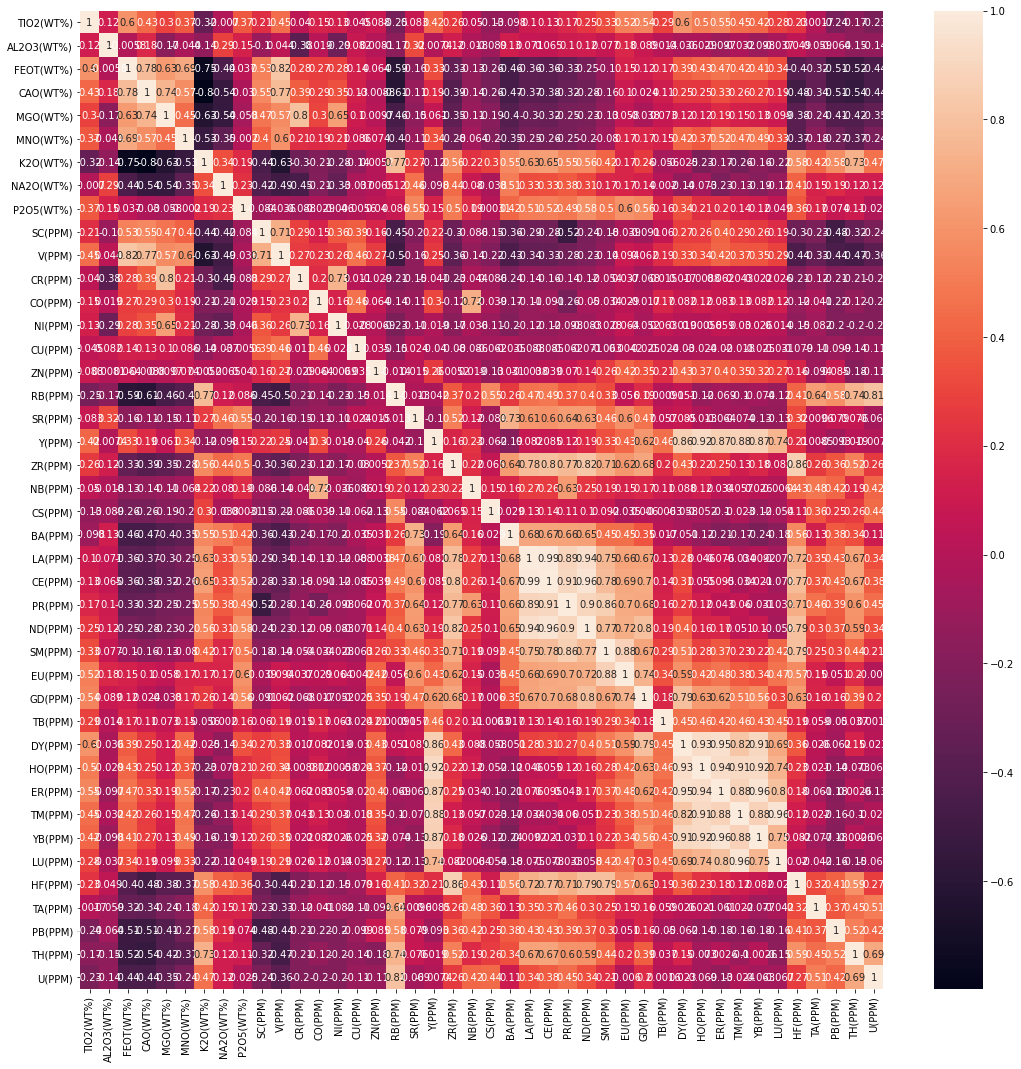

In [14]:
import seaborn as sns

corr_df = train.corr(method='pearson')
plt.figure(figsize=(18,18))
sns.heatmap(corr_df, annot = True)

## 결측치 처리

In [15]:
from sklearn.impute import KNNImputer
#imputer = KNNImputer(n_neighbors=50)
#train = imputer.fit_transform(train)

from sklearn.impute import SimpleImputer
#imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
#train = imp_mean.fit_transform(train)

In [16]:
from scipy import interpolate

def interp(col1, col2):
  f = interpolate.interp1d(train[col1].values, train[col2].values, fill_value="extrapolate")
  train[col2] = np.where(train[col2].isnull(), f(train[col1]), train[col2])


In [17]:
!pip install missingpy
from missingpy import MissForest

UseCols = train.columns.tolist()
MISSForest_algo = MissForest(verbose = 0, n_jobs  = -1 , max_depth=10)
MISSForest_algo.fit(X = train)
train = MISSForest_algo.transform(train)
train = pd.DataFrame(train, columns= UseCols)

train.isna().sum()

     |████████████████████████████████| 49 kB 1.6 MB/s 


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5


TIO2(WT%)     0
AL2O3(WT%)    0
FEOT(WT%)     0
CAO(WT%)      0
MGO(WT%)      0
MNO(WT%)      0
K2O(WT%)      0
NA2O(WT%)     0
P2O5(WT%)     0
SC(PPM)       0
V(PPM)        0
CR(PPM)       0
CO(PPM)       0
NI(PPM)       0
CU(PPM)       0
ZN(PPM)       0
RB(PPM)       0
SR(PPM)       0
Y(PPM)        0
ZR(PPM)       0
NB(PPM)       0
CS(PPM)       0
BA(PPM)       0
LA(PPM)       0
CE(PPM)       0
PR(PPM)       0
ND(PPM)       0
SM(PPM)       0
EU(PPM)       0
GD(PPM)       0
TB(PPM)       0
DY(PPM)       0
HO(PPM)       0
ER(PPM)       0
TM(PPM)       0
YB(PPM)       0
LU(PPM)       0
HF(PPM)       0
TA(PPM)       0
PB(PPM)       0
TH(PPM)       0
U(PPM)        0
dtype: int64

## Feature Engineering

In [18]:
# 필요한 피처들만 가져와서 사용
#train = train[['TIO2(WT%)',	'AL2O3(WT%)',	'FEOT(WT%)',	'CAO(WT%)'	,'MGO(WT%)',	'MNO(WT%)',	'K2O(WT%)',	'NA2O(WT%)',	'P2O5(WT%)', 'LA(PPM)', 'Y(PPM)', 'CE(PPM)', 'YB(PPM)','SR(PPM)']]
#test = test[['TIO2(WT%)',	'AL2O3(WT%)',	'FEOT(WT%)',	'CAO(WT%)'	,'MGO(WT%)',	'MNO(WT%)',	'K2O(WT%)',	'NA2O(WT%)',	'P2O5(WT%)', 'LA(PPM)', 'Y(PPM)', 'CE(PPM)', 'YB(PPM)','SR(PPM)']]

In [19]:
train['sum'] = train.sum(axis=1)
test['sum'] = test.sum(axis=1)

In [20]:
'''
train['SR/Y'] = round(train['SR(PPM)'] / train['Y(PPM)'], 2)
#train['CE/Y'] = round(train['CE(PPM)'] / train['Y(PPM)'], 2)
train['LA/YB'] = round(train['LA(PPM)'] / train['YB(PPM)'],2)

test['SR/Y'] = round(test['SR(PPM)'] / test['Y(PPM)'],2)
#test['CE/Y'] = round(test['CE(PPM)'] / test['Y(PPM)'], 2)
test['LA/YB'] = round(test['LA(PPM)'] / test['YB(PPM)'],2)

train.replace([np.inf, -np.inf], np.nan, inplace=True)
test.replace([np.inf, -np.inf], np.nan, inplace=True)

replace(train, ['SR/Y', 'LA/YB'])
replace(test, ['SR/Y', 'LA/YB'])
'''

"\ntrain['SR/Y'] = round(train['SR(PPM)'] / train['Y(PPM)'], 2)\n#train['CE/Y'] = round(train['CE(PPM)'] / train['Y(PPM)'], 2)\ntrain['LA/YB'] = round(train['LA(PPM)'] / train['YB(PPM)'],2)\n\ntest['SR/Y'] = round(test['SR(PPM)'] / test['Y(PPM)'],2)\n#test['CE/Y'] = round(test['CE(PPM)'] / test['Y(PPM)'], 2)\ntest['LA/YB'] = round(test['LA(PPM)'] / test['YB(PPM)'],2)\n\ntrain.replace([np.inf, -np.inf], np.nan, inplace=True)\ntest.replace([np.inf, -np.inf], np.nan, inplace=True)\n\nreplace(train, ['SR/Y', 'LA/YB'])\nreplace(test, ['SR/Y', 'LA/YB'])\n"

In [21]:
train['alcali'] = [1 if mgo > 7 else 0 for mgo in train['MGO(WT%)']]
test['alcali'] = [1 if mgo > 7 else 0 for mgo in test['MGO(WT%)']]

In [22]:
display(train)

,TIO2(WT%),AL2O3(WT%),FEOT(WT%),CAO(WT%),MGO(WT%),MNO(WT%),K2O(WT%),NA2O(WT%),P2O5(WT%),SC(PPM),V(PPM),CR(PPM),CO(PPM),NI(PPM),CU(PPM),ZN(PPM),RB(PPM),SR(PPM),Y(PPM),ZR(PPM),NB(PPM),CS(PPM),BA(PPM),LA(PPM),CE(PPM),PR(PPM),ND(PPM),SM(PPM),EU(PPM),GD(PPM),TB(PPM),DY(PPM),HO(PPM),ER(PPM),TM(PPM),YB(PPM),LU(PPM),HF(PPM),TA(PPM),PB(PPM),TH(PPM),U(PPM),sum,alcali
0,0.560,16.000,6.703510,6.600,5.100,0.110,1.300,3.61,0.150,18.000000,177.000000,165.000000,33.000000,81.000000,42.239145,74.753355,29.000000,505.000000,10.800000,81.000000,3.000000,0.859345,550.000000,12.100000,25.000000,3.072994,13.000000,2.600000,0.770000,2.400000,0.334130,2.000000,0.398057,1.100000,0.159968,0.990000,0.154490,2.355627,0.207961,6.312726,2.650000,0.832601,1887.223909,0
1,1.130,17.210,8.886916,12.120,7.680,0.150,0.240,2.70,0.100,36.344284,265.550832,255.663731,37.286268,92.626559,92.938887,71.857969,4.575489,159.688390,24.254889,70.175573,2.860643,0.180461,36.638968,3.350262,9.460098,1.576928,7.952041,2.647418,0.987011,3.366045,0.591958,3.796369,0.827734,2.357360,0.369909,2.338164,0.377492,1.789413,0.176896,1.420410,0.322615,0.145383,1244.713368,1
2,0.530,16.150,2.996334,3.980,1.990,0.060,2.180,4.58,0.180,8.050000,68.700000,47.800000,6.380000,10.800000,6.490000,80.400000,65.200000,756.000000,11.500000,161.000000,5.650000,2.140000,1521.000000,24.800000,47.500000,5.920000,22.700000,4.230000,1.110000,3.500000,0.461000,2.400000,0.429000,1.130000,0.156000,1.000000,0.142000,4.156088,0.339000,16.700000,7.000000,2.350000,2929.779422,0
3,1.150,15.100,7.891246,7.740,7.930,0.120,1.670,3.01,0.270,24.050000,177.855234,352.838263,34.203951,154.303221,47.199006,86.533238,47.000000,490.000000,18.830000,172.000000,12.500000,1.310000,409.000000,35.300000,67.900000,7.510000,30.300000,5.720000,1.390000,5.200000,0.660000,3.840000,0.700000,1.980000,0.300000,1.880000,0.260000,6.740000,0.780000,9.100000,7.600000,1.200000,2260.864159,1
4,0.420,15.950,3.761164,4.090,1.900,0.060,2.470,4.42,0.140,7.000000,54.000000,32.000000,11.000000,16.000000,45.289268,73.388678,68.000000,555.000000,7.000000,28.000000,3.600000,2.658280,935.000000,23.000000,43.000000,5.163001,18.500000,3.400000,0.900000,2.400000,0.287537,1.350000,0.220244,0.600000,0.085158,0.500000,0.074613,1.547428,0.229792,14.890241,5.100000,1.677147,1994.072551,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7268,0.530,11.750,9.528882,12.540,9.940,0.160,2.740,1.33,0.370,44.400000,239.000000,363.000000,44.500000,78.000000,101.344941,75.729432,47.000000,1169.000000,15.000000,40.000000,1.282946,1.090000,672.000000,7.600000,15.800000,2.190084,9.600000,2.880000,0.990000,3.193022,0.530000,2.768784,0.541950,1.497823,0.216476,1.400000,0.200000,1.020000,0.030000,5.000000,0.910000,0.600000,2997.204341,1
7269,1.690,16.190,6.800000,9.990,7.630,0.110,1.700,3.83,0.810,21.091301,194.215693,345.490551,37.517593,143.309068,57.597459,98.484944,41.790854,1008.029332,23.011306,148.436440,12.084965,1.220784,731.094050,26.768808,54.135477,6.339516,25.558977,5.673940,1.770128,5.213762,0.755150,4.135306,0.807247,2.253271,0.332515,2.086679,0.304669,3.919506,0.714374,10.002820,5.451737,1.498875,3069.847098,1
7270,1.510,16.370,8.250000,9.740,5.430,0.200,0.400,3.44,0.220,53.140121,296.000000,80.000000,58.000000,52.000000,123.966972,123.591562,5.400000,193.000000,31.000000,116.000000,0.000000,0.269979,38.000000,6.790000,17.100000,2.692199,13.420000,4.020000,1.450000,4.739772,0.840000,5.249596,1.146598,3.242801,0.489116,3.260000,0.482000,2.984465,0.294299,1.824721,0.460596,0.253318,1286.668114,0
7271,0.590,17.920,6.514552,6.990,3.170,0.120,1.110,3.81,0.160,14.974719,144.794748,30.719457,18.173772,15.351869,41.835290,75.169314,12.616440,513.970652,12.706569,88.982648,3.697229,0.348840,517.378137,9.608943,17.739124,2.507644,10.808273,2.650903,0.704437,2.422866,0.375695,2.288827,0.413315,1.014516,0.183592,1.196026,0.184885,2.284323,

In [23]:
display(test)

,TIO2(WT%),AL2O3(WT%),FEOT(WT%),CAO(WT%),MGO(WT%),MNO(WT%),K2O(WT%),NA2O(WT%),P2O5(WT%),SC(PPM),V(PPM),CR(PPM),CO(PPM),NI(PPM),CU(PPM),ZN(PPM),RB(PPM),SR(PPM),Y(PPM),ZR(PPM),NB(PPM),CS(PPM),BA(PPM),LA(PPM),CE(PPM),PR(PPM),ND(PPM),SM(PPM),EU(PPM),GD(PPM),TB(PPM),DY(PPM),HO(PPM),ER(PPM),TM(PPM),YB(PPM),LU(PPM),HF(PPM),TA(PPM),PB(PPM),TH(PPM),U(PPM),sum,alcali
0,1.00000,15.34000,8.740000,13.30000,7.68000,0.14000,0.26000,2.33000,0.09000,39.419761,264.235040,298.191685,40.741070,102.035872,93.808322,68.583517,5.111586,148.980391,22.755959,50.203352,1.570279,0.128355,36.125974,3.587330,9.172711,1.455107,7.418125,2.517975,0.957632,3.032573,0.521706,3.445595,0.753475,2.175624,0.329385,2.089226,0.324914,1.407370,0.108011,0.843640,0.305881,0.115163,1261.332604,1
1,1.10592,14.37506,11.438840,12.36156,7.16606,0.20634,0.04654,2.45716,0.07312,44.178022,333.120353,61.324963,49.626789,59.147545,130.139826,103.477341,0.533042,63.740163,26.635604,51.645219,0.706426,0.005765,4.860177,1.438734,5.181906,0.965136,5.679726,2.270337,0.896736,3.609905,0.691708,4.625839,1.021353,2.987150,0.442955,2.974130,0.449079,1.414753,0.044261,0.377547,0.074079,0.024858,1013.542028,1
2,0.57000,17.10000,9.699922,4.53000,2.55000,0.09000,1.13000,4.53000,0.05000,11.000000,106.000000,75.000000,18.336469,27.000000,33.717415,78.814423,8.900000,452.000000,8.800000,132.000000,3.700000,0.440331,660.000000,8.800000,20.500000,2.344961,9.700000,1.900000,0.820000,1.950000,0.269828,1.600000,0.311089,0.850000,0.123287,0.880000,0.129984,2.473764,0.259204,5.950845,2.200000,0.806990,1717.828511,0
3,1.31000,15.99000,8.043628,10.96000,6.70000,0.16000,0.48000,2.94000,0.17000,35.200000,252.000000,109.000000,32.700000,52.300000,48.900000,65.800000,6.240000,200.000000,26.500000,91.800000,4.300000,0.320000,52.600000,5.620000,14.200000,2.170000,11.400000,3.490000,1.290000,3.858417,0.770000,5.000000,1.060000,3.090000,0.480000,3.040000,0.440000,2.710000,0.330000,2.520000,0.450000,0.190000,1086.522045,0
4,1.40000,17.98000,9.780000,9.11000,3.28000,0.17000,1.66000,3.33000,0.32000,24.720000,225.000000,30.100000,26.000000,8.000000,64.853091,113.980633,31.000000,935.000000,17.000000,94.000000,9.000000,1.100000,592.000000,25.400000,51.000000,6.138364,26.000000,5.780000,1.990000,5.496627,0.800000,4.293143,0.841318,2.408336,0.383675,2.400000,0.400000,2.900000,0.500000,6.000000,3.400000,0.700000,2365.615187,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2274,0.69000,16.95000,5.083870,5.20000,2.30000,0.09000,2.36000,4.15000,0.28000,9.500000,112.000000,18.000000,15.000000,16.000000,46.958837,80.486079,47.000000,810.000000,12.200000,172.000000,6.900000,1.135212,1080.000000,34.500000,65.000000,7.600183,29.500000,4.633958,1.260000,3.450670,0.456055,2.200000,0.433886,1.300000,0.172841,1.030000,0.159228,4.141983,0.494936,11.236254,3.400000,0.716591,2635.970584,0
2275,1.81000,16.70000,7.576316,6.88000,4.27000,0.09000,2.26000,4.23000,0.75000,3.000000,62.000000,1.000000,1.000000,2.000000,20.000000,37.000000,235.898000,20.797000,18.312000,89.982000,21.559000,6.400000,47.700000,25.442000,56.500000,6.069000,20.949000,3.996000,0.262000,3.208000,0.437000,2.759000,0.526000,1.428000,0.276000,1.784000,0.261000,3.129000,2.372000,20.585000,37.332000,8.223000,806.752316,0
2276,0.80000,14.60000,5.700000,3.60000,1.20000,0.16000,2.80000,3.60000,0.28000,17.000000,39.248826,1.000000,9.000000,1.000000,23.000000,92.750800,51.000000,222.000000,39.000000,208.000000,7.000000,1.700000,451.000000,15.480000,34.530000,4.900000,22.240000,5.950000,1.480000,6.500000,1.070000,6.920000,1.440000,4.310000,0.640000,4.310000,0.640000,5.530000,0.524752,6.600000,2.600000,1.400000,1322.504378,0
2277,2.65000,14.10000,11.060000,5.70000,1.80000,0.22000,2.40000,3.40000,0.64000,19.766414,215.934803,57.331893,30.571087,31.335708,52.837793,248.508029,76.846510,815.428355,31.281400,181.783300,23.875300,4.855954,938.798406,2

## 모델 훈련

In [24]:
X = train.copy()

In [25]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(5818, 44)
(1455, 44)
(5818,)
(1455,)


In [26]:
# Random Forest 모델로 학습
random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
y_pred=random_forest.predict(X_val)

print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       903
           1       0.98      0.97      0.97       552

    accuracy                           0.98      1455
   macro avg       0.98      0.98      0.98      1455
weighted avg       0.98      0.98      0.98      1455



In [27]:
#random_forest = RandomForestClassifier()
#random_forest.fit(X, y)

In [28]:
y_pred = random_forest.predict(test)
test['Thickness'] = y_pred.astype(int)
submission = test['Thickness']
submission.to_csv(os.path.join(data_path, "submission.csv"), index=False)
display(submission)

0       1
1       1
2       0
3       1
4       1
       ..
2274    0
2275    0
2276    1
2277    0
2278    0
Name: Thickness, Length: 2279, dtype: int64

In [29]:
pred = test.pop('Thickness')